<a href="https://colab.research.google.com/github/Kamna-S/Image-Classification-Project-Using-DenseNet121-and-Streamlit/blob/main/Defective_and_Non_Defective_Industrial_Equipment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DenseNet121***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total number of images in training set: 432
Total number of images in testing set: 317
Found 346 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6990 - loss: 3.6065 - val_accuracy: 0.7209 - val_loss: 2.8931
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.8328 - loss: 2.5748 - val_accuracy: 0.9767 - val_loss: 2.0044
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9189 - loss: 2.0976 - val_accuracy: 0.9302 - val_loss: 2.0473
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 1.0000 - loss: 1.9823
Test accuracy: 1.00
317/317 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step
Classification Report:
               precision    recall  f1-score   support

non-defective       1.00      1.00      1.00       159
    defective       1.00      1.00      1.00       158

     accuracy                           1.00       317
    macro avg       1.00      1.00      1.00       317
 weighted avg       1.00      1.00      1.00       317

Confusion Matrix:
[[159   0]
 [  0 158]]


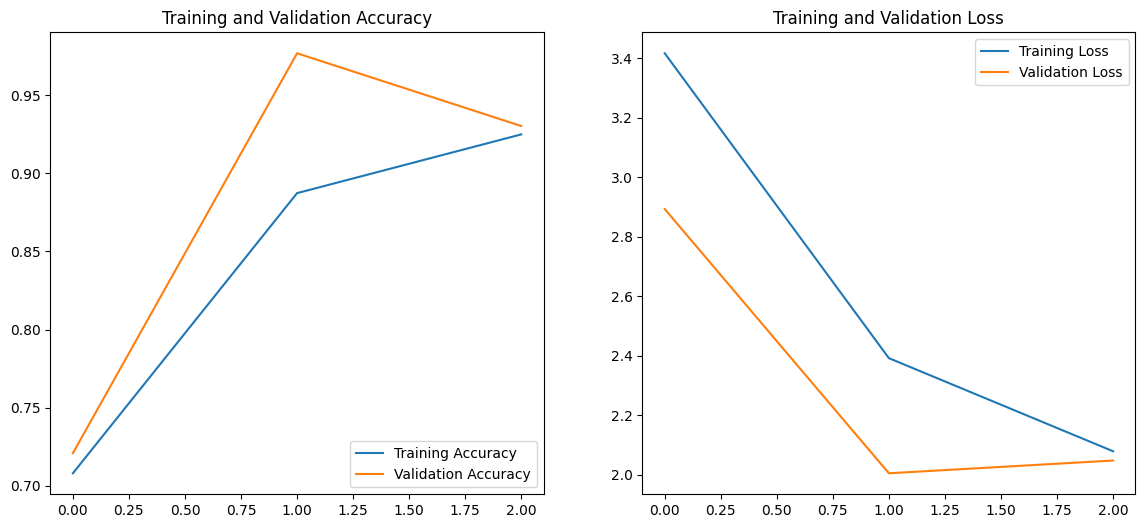

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths to your data
train_dir = '/content/drive/MyDrive/Tools/Train'      # Training directory containing 'defective' and 'non-defective' folders
test_dir = '/content/drive/MyDrive/Tools/Test'        # Testing directory containing 'defective' and 'non-defective' folders

# Model parameters
batch_size = 32
img_height = 224
img_width = 224
num_epochs = 2
learning_rate = 0.0001

# Count total images in the training and testing folders
def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                count += 1
    return count

total_train_images = count_images_in_folder(train_dir)
total_test_images = count_images_in_folder(test_dir)

# Print the counts
print(f"Total number of images in training set: {total_train_images}")
print(f"Total number of images in testing set: {total_test_images}")

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

# Training data generator (80% of data)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Validation data generator (20% of data)
validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Load pre-trained DenseNet121 model and freeze initial layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model's layers

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification (defective or non-defective)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=validation_data
)

# Unfreeze the last few layers of the DenseNet121 model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=learning_rate / 10),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_data,
    epochs=int(num_epochs / 2),  # Reduced epochs for fine-tuning
    validation_data=validation_data
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy:.2f}")

# Get predictions and classification report
y_pred = (model.predict(test_data) > 0.5).astype("int32")
y_true = test_data.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['non-defective', 'defective']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



# Plot training and validation accuracy and loss
def plot_history(history, fine_tune_history=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune_history:
        acc += fine_tune_history.history['accuracy']
        val_acc += fine_tune_history.history['val_accuracy']
        loss += fine_tune_history.history['loss']
        val_loss += fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot the combined history
plot_history(history, fine_tune_history)


In [ ]:
# Save the model
model.save('defect_detection_model_densenet121.h5')
print("Model saved as defect_detection_model_densenet121.h5")

Model saved as defect_detection_model_densenet121.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


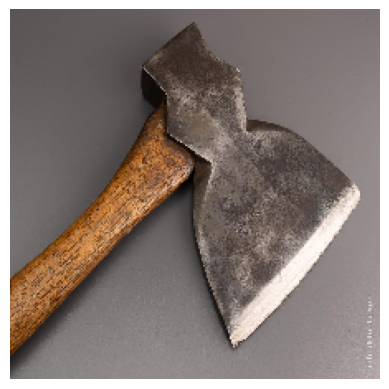

Predicted class: Non-Defective (Confidence: 100.00%)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image to [0, 1]
    return img_array

# Path to the image you want to test (e.g., an image from the test set)
img_path = '/content/drive/MyDrive/Tools/Test/Non-Defective-test/97013_1000x.jpg'  # Update with actual path

# Preprocess the image
img = preprocess_image(img_path)

# Make a prediction on the image
# Make a prediction on the image
prediction = model.predict(img)

# Show the image
img_display = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img_display)
plt.axis('off')  # Hide axes
plt.show()

# Print the prediction result with actual probability value
if prediction > 0.5:
    print(f"Predicted class: Non-Defective (Confidence: {prediction[0][0]*100:.2f}%)")
else:
    print(f"Predicted class: Defective (Confidence: {100 - prediction[0][0]*100:.2f}%)")

